In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew

In [2]:
# read csv
df = pd.read_csv('groww_cleaned_data.csv')
df.head()

,fund_name,risk,category,rating,1y_return,3y_return,5y_return,1y_return_band,3y_return_band,5y_return_band,avg_return,risk_score,risk_adjusted_return,return_std,fund_age,rank
0,HDFC Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,159.93,53.58,NaN,High,High,No Data,106.755000,7,15.250714,75.200806,2,6.0
1,SBI Gold Direct Plan Growth,Very High Risk,Commodities,4.0,78.67,37.57,25.18,High,High,High,47.140000,7,6.734286,27.999709,3,21.0
2,Parag Parikh Flexi Cap Fund Direct Growth,Very High Risk,Equity,5.0,6.89,20.72,18.76,Moderate,High,High,15.456667,7,2.208095,7.483397,3,350.0
3,Bandhan Small Cap Fund Direct Growth,Very High Risk,Equity,5.0,9.51,32.50,25.94,Moderate,High,High,22.650000,7,3.235714,11.842850,3,79.0
4,Motilal Oswal Midcap Fund Direct Growth,Very High Risk,Equity,3.0,-1.04,24.93,26.08,Loss,High,High,16.656667,7,2.379524,15.336546,3,253.0


#### Performance variables

- 1y_return
- 3y_return
- 5y_return
- avg_return
- risk_adjusted_return

#### Risk variables

- risk
- risk_score
- return_std

#### Segmentation variables

- category
- return bands

#### Target / evaluation variable

- rank
- rating

### Business Questions

- Which category gives the best risk-adjusted returns?
- Does higher risk actually produce higher returns?
- What factors influence fund ranking?
- Are highly rated funds really better performers?
- Which mutual fund characteristics drive higher rank and better risk-adjusted performance?

In [3]:
df.isnull().sum()

fund_name                 0
risk                      0
category                  0
rating                    0
1y_return                 0
3y_return               325
5y_return               574
1y_return_band            0
3y_return_band            0
5y_return_band            0
avg_return                0
risk_score                0
risk_adjusted_return      0
return_std              325
fund_age                  0
rank                      0
dtype: int64

In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.describe()

,rating,1y_return,3y_return,5y_return,avg_return,risk_score,risk_adjusted_return,return_std,fund_age,rank
count,1429.000000,1429.000000,1104.000000,855.000000,1429.000000,1429.000000,1429.000000,1104.000000,1429.000000,1429.000000
mean,3.010497,10.806543,14.582201,12.183310,12.434903,5.559832,2.417430,4.412995,2.370889,715.000000
std,0.878805,16.246895,7.490306,6.053059,12.905827,1.903876,2.059427,6.938175,0.829865,412.660988
min,1.000000,-15.760000,3.830000,-1.140000,-15.760000,1.000000,-2.251429,0.028284,1.000000,1.000000
25%,3.000000,6.170000,7.690000,6.390000,6.986667,4.000000,1.670000,0.699523,2.000000,358.000000
50%,3.000000,7.580000,14.095000,11.510000,10.410000,7.000000,2.016667,2.544907,3.000000,715.000000
75%,3.000000,11.010000,19.495000,16.300000,15.250000,7.000000,2.501111,5.743190,3.000000,1071.500000
max,5.000000,164.160000,53.630000,32.780000,164.160000,7.000000,23.451429,75.724065,3.000000,1429.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fund_name             1429 non-null   object 
 1   risk                  1429 non-null   object 
 2   category              1429 non-null   object 
 3   rating                1429 non-null   float64
 4   1y_return             1429 non-null   float64
 5   3y_return             1104 non-null   float64
 6   5y_return             855 non-null    float64
 7   1y_return_band        1429 non-null   object 
 8   3y_return_band        1429 non-null   object 
 9   5y_return_band        1429 non-null   object 
 10  avg_return            1429 non-null   float64
 11  risk_score            1429 non-null   int64  
 12  risk_adjusted_return  1429 non-null   float64
 13  return_std            1104 non-null   float64
 14  fund_age              1429 non-null   int64  
 15  rank                 

In [7]:
print(f'No.of unique categories: {df['category'].nunique()}\n{df['category'].unique()}')
print('--'*15)
print(df['risk'].value_counts())

No.of unique categories: 4
['Commodities' 'Equity' 'Hybrid' 'Debt']
------------------------------
risk
Very High Risk          823
Moderate Risk           215
Low to Moderate Risk    160
Moderately High Risk     91
Low Risk                 76
High Risk                60
Moderately Low Risk       4
Name: count, dtype: int64


In [8]:
def preprocess_funds(df):
    # Drop nulls for EDA
    df_eda = df.dropna(subset=['3y_return', '5y_return', 'return_std'])
    
    # Fill nulls for modeling
    df_model = df.copy()
    for col in ['3y_return', '5y_return', 'return_std']:
        df_model[col] = df_model[col].fillna(df_model[col].median())
        df_model[col + '_missing'] = df[col].isnull().astype(int)
    
    return df_eda, df_model

df_eda, df_model = preprocess_funds(df)

- Median used due to skewed distribution
- Rows dropped where key metrics missing

## Distribution (Univariate Insights)

- Purpose: Understand spread and skewness of key variables

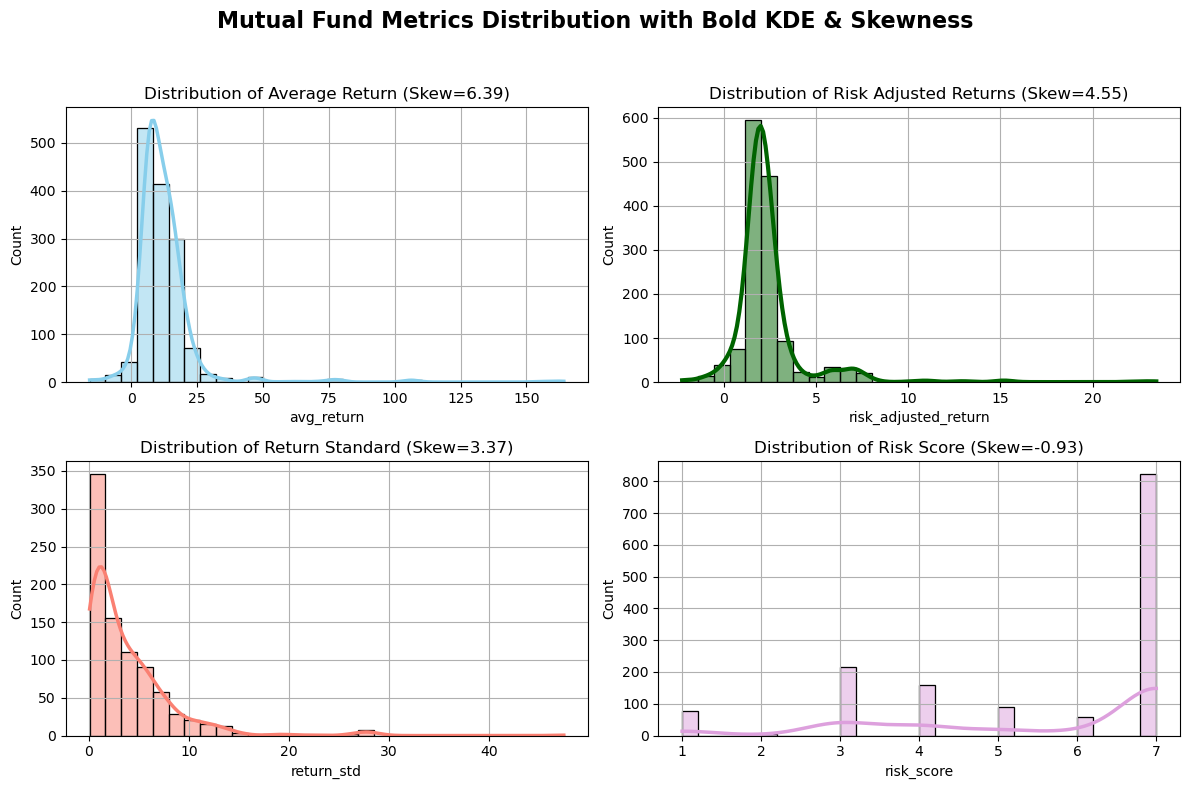

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histogram for avg_return
sns.histplot(df['avg_return'], bins=30, kde=True, color='skyblue',
             edgecolor='black', ax=axs[0, 0],
             line_kws={'linewidth': 2.5, 'color': 'black'})
axs[0, 0].set_title(f'Distribution of Average Return (Skew={skew(df["avg_return"]):.2f})')
axs[0, 0].grid(True)

# Histogram for risk_adjusted_return
sns.histplot(df['risk_adjusted_return'], bins=30, kde=True, color='darkgreen',
             edgecolor='black', ax=axs[0, 1],
             line_kws={'linewidth': 3, 'color': 'black'})
axs[0, 1].set_title(f'Distribution of Risk Adjusted Returns (Skew={skew(df["risk_adjusted_return"]):.2f})')
axs[0, 1].grid(True)

# Histogram for return_std
sns.histplot(df_eda['return_std'], bins=30, kde=True, color='salmon',
             edgecolor='black', ax=axs[1, 0],
             line_kws={'linewidth': 2.5, 'color': 'black'})
axs[1, 0].set_title(f'Distribution of Return Standard (Skew={skew(df_eda["return_std"]):.2f})')
axs[1, 0].grid(True)

# Histogram for risk_score
sns.histplot(df['risk_score'], bins=30, kde=True, color='plum',
             edgecolor='black', ax=axs[1, 1],
             line_kws={'linewidth': 2.5, 'color': 'black'})
axs[1, 1].set_title(f'Distribution of Risk Score (Skew={skew(df["risk_score"]):.2f})')
axs[1, 1].grid(True)

# Add one single super-title for the whole figure
fig.suptitle('Mutual Fund Metrics Distribution with Bold KDE & Skewness', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Key Observations
- Average Return (Skew = 6.39)
    - Strong positive skew.
    - Most funds cluster at lower average returns, but a few outliers deliver extremely high returns.
    - Indicates that a small number of funds disproportionately drive the average upward.

- Risk‑Adjusted Return (Skew = 4.55)
    - Also positively skewed.
    - Majority of funds have modest efficiency, while a handful achieve very high risk‑adjusted returns.
    - Suggests that only select funds manage risk exceptionally well relative to returns.

- Return Standard Deviation (Skew = 3.37)
    - Positively skewed distribution of volatility.
    - Most funds exhibit low to moderate volatility, but a few are highly volatile.
    - Confirms that extreme risk is concentrated in a minority of funds.

- Risk Score (Skew = –0.93)
    - Negatively skewed.
    - Distribution peaks at higher risk scores, meaning more funds are classified as high‑risk.
    - Fewer funds fall into low‑risk categories.

### Insights
- Outlier‑driven performance: Both average and risk‑adjusted returns are skewed by a small number of standout funds, while most funds deliver modest outcomes.
- Volatility concentration: Most funds are relatively stable, but a minority carry extreme volatility, which investors should watch closely.
- Risk profile imbalance: The negative skew in risk scores shows that the fund universe leans toward higher risk categories, limiting safe options.

In [10]:
df.isnull().sum()

fund_name                 0
risk                      0
category                  0
rating                    0
1y_return                 0
3y_return               325
5y_return               574
1y_return_band            0
3y_return_band            0
5y_return_band            0
avg_return                0
risk_score                0
risk_adjusted_return      0
return_std              325
fund_age                  0
rank                      0
dtype: int64

# Outliers

- Purpose: Identify extreme behavior and decide whether to treat.

In [11]:
# IQR method

q1 = df['avg_return'].quantile(0.25)
q3 = df['avg_return'].quantile(0.75)
iqr = q3 - q1

lw = q1-1.5*iqr
uw = q3+1.5*iqr

outliers = df[(df['avg_return'] < lw) | (df['avg_return'] > uw)]
print('No.of outlier funds:',len(outliers), '\n\n',outliers.head())

No.of outlier funds: 58 

                                             fund_name            risk  \
0                   HDFC Silver ETF FoF Direct Growth  Very High Risk   
1                         SBI Gold Direct Plan Growth  Very High Risk   
5           Nippon India Silver ETF FoF Direct Growth  Very High Risk   
7                     Tata Gold ETF FoF Direct Growth       High Risk   
10  Aditya Birla Sun Life Silver ETF FoF Direct Gr...  Very High Risk   

       category  rating  1y_return  3y_return  5y_return 1y_return_band  \
0   Commodities     3.0     159.93      53.58        NaN           High   
1   Commodities     4.0      78.67      37.57      25.18           High   
5   Commodities     3.0     158.60      53.12        NaN           High   
7   Commodities     5.0      75.74        NaN        NaN           High   
10  Commodities     3.0     158.57      52.99        NaN           High   

   3y_return_band 5y_return_band  avg_return  risk_score  \
0            High      

In [12]:
outliers['category'].value_counts()

category
Commodities    29
Equity         29
Name: count, dtype: int64

Outlier analysis revealed that extreme return values are concentrated in Equity and Commodity funds. This is consistent with financial market behavior, as these categories exhibit higher volatility and cyclic performance. Therefore, outliers were retained for analysis.

In [13]:
outliers[['category','avg_return','return_std']].head(10)

,category,avg_return,return_std
0,Commodities,106.755000,75.200806
1,Commodities,47.140000,27.999709
5,Commodities,105.860000,74.585623
7,Commodities,75.740000,NaN
10,Commodities,105.780000,74.656334
12,Equity,30.056667,4.682225
14,Commodities,70.220000,40.305087
15,Commodities,47.010000,28.025472
16,Commodities,164.160000,NaN
17,Commodities,78.545000,48.627733


Analysing the table, we can observe that the funds with high volatility lead to high return and resulting with high average returns, are mostly concentrated in commodities and equity funds. As recently, there is sudden surge in the market for rare-earth minerals like gold and silver, these funds have high returns and high volatility. These outliers should not be considered as noise. 

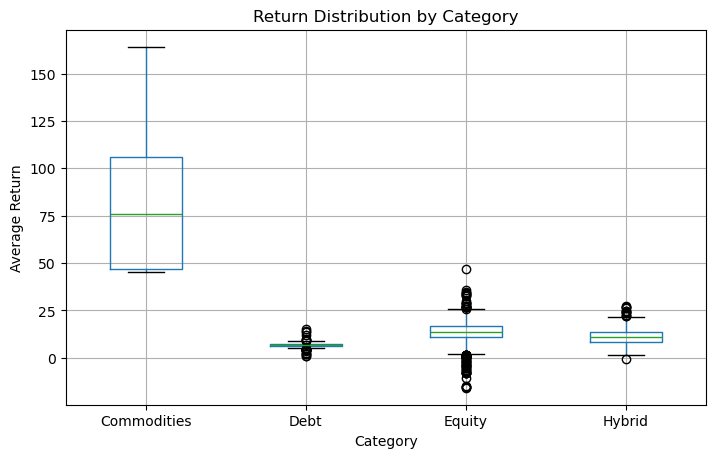

In [14]:
df.boxplot(column='avg_return', by='category', figsize=(8,5))
plt.title('Return Distribution by Category')
plt.suptitle("")
plt.xlabel('Category')
plt.ylabel('Average Return')
plt.show()

### Key Observations
- Commodities
    - Widest spread of returns, ranging from ~45 up to 160+.
    - Median around 75, much higher than other categories.
    - Indicates both high upside potential and high variability.

- Debt
    - Very narrow distribution, clustered tightly between ~5–10.
    - Median is low, reflecting predictable but limited growth.
    - Almost no outliers, confirming stability.

- Equity
    - Wider spread than Debt, with median around 15.
    - Several outliers both above and below, showing variability.
    - Offers higher growth potential but with more risk.

- Hybrid
    - Similar spread to Equity, median around 12.
    - A few outliers, but generally more balanced than pure equity.
    - Reflects its blended nature — moderate returns with moderate risk.

### Insights
- Risk–return trade‑off across categories: Commodities deliver the highest returns but also the widest variability, while Debt offers stability at the cost of growth.
- Equity vs Hybrid: Equity provides stronger median returns but with more volatility; Hybrid smooths some of that risk while sacrificing a bit of upside.

In [15]:
df.groupby('category')['avg_return'].median().sort_values()

category
Debt            6.973333
Hybrid         10.791667
Equity         13.876667
Commodities    75.740000
Name: avg_return, dtype: float64

Commodity and Equity funds exhibit wider return distributions and more extreme outliers, indicating higher volatility. Debt funds show tightly clustered returns, reflecting stability, while Hybrid funds maintain moderate variability due to diversified allocation.

- Stable → Debt
- Balanced → Hybrid
- High growth -> Equity
- High risk/high reward -> Commodities

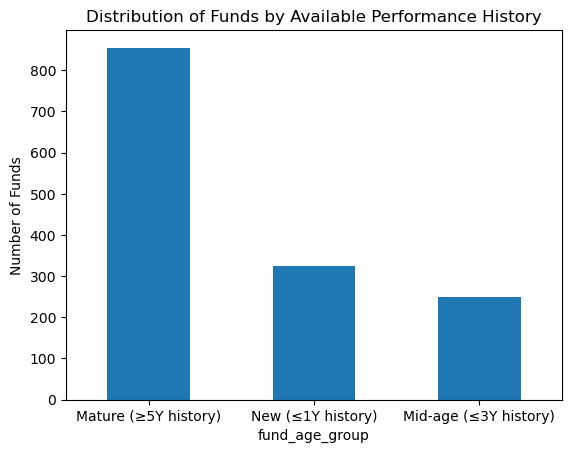

In [16]:
def age_label(x):
    if x == 1:
        return "New (≤1Y history)"
    elif x == 2:
        return "Mid-age (≤3Y history)"
    else:
        return "Mature (≥5Y history)"

df['fund_age_group'] = df['fund_age'].apply(age_label)


df['fund_age_group'].value_counts().plot(kind='bar')
plt.title("Distribution of Funds by Available Performance History")
plt.ylabel("Number of Funds")
plt.xticks(rotation=0)
plt.show()

### Key Observations
- Mature funds (≥5Y history) dominate the dataset, with over 850 funds.
- New funds (≤1Y history) are the second largest group, around 330 funds.
- Mid-age funds (≤3Y history) are the smallest group, about 260 funds.

### Insights
- Data richness in mature funds: The majority of funds have long performance histories, which is valuable for analysis. Investors and analysts can rely on these funds for robust trend evaluation and risk assessment.
- Limited mid-age representation: The relatively small number of 3‑year history funds suggests that many funds either remain very new or have already matured into the 5‑year category. This gap could affect medium‑term comparative studies.

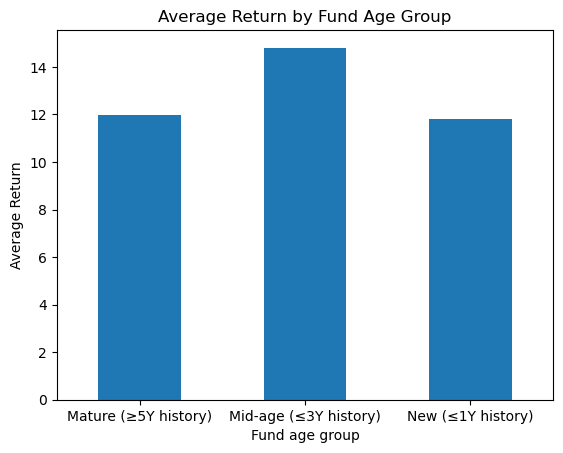

In [17]:
df.groupby('fund_age_group')['avg_return'].mean().plot(kind='bar')
plt.title("Average Return by Fund Age Group")
plt.xlabel('Fund age group')
plt.ylabel("Average Return")
plt.xticks(rotation=0)
plt.show()

### Key Observations
- Mid‑age funds (≤3Y history) deliver the highest average returns among the three groups.
- Mature funds (≥5Y history) show solid but slightly lower average returns compared to mid‑age funds.
- New funds (≤1Y history) have the lowest average returns, lagging behind both mid‑age and mature funds.

### Insights
- Performance sweet spot: Mid‑age funds appear to be in a “sweet spot” — they’ve survived the initial volatility of new funds and are still agile enough to capture growth opportunities.
- Stability vs. growth trade‑off: Mature funds provide stability and reliability due to their long track record, but their average returns suggest they may be less aggressive in chasing growth compared to mid‑age funds.
- New fund risk: New funds underperform on average, likely due to lack of established strategies, higher startup costs, or market testing phases. This reinforces the need for caution when investing in funds with very limited history.

## Which category gives the best risk-adjusted returns?

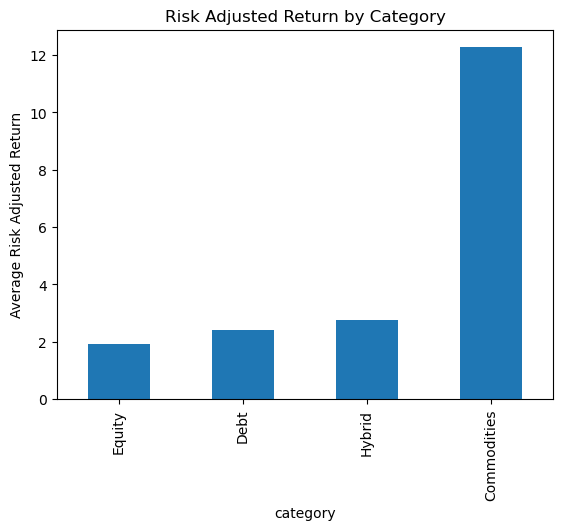

In [18]:
df.groupby('category')['risk_adjusted_return'].mean().sort_values().plot(kind='bar')
plt.title("Risk Adjusted Return by Category")
plt.ylabel("Average Risk Adjusted Return")
plt.show()

### Key Observations
- Commodities stand out with a much higher average risk‑adjusted return (≈12+) compared to all other categories.
- Equity, Debt, and Hybrid categories cluster together with relatively modest values (≈2–3).
- The gap between Commodities and the rest is very wide, showing a clear outlier in performance.

### Insights
- Commodities outperform significantly: When adjusted for risk, commodities deliver far superior returns, suggesting they provide strong compensation for the volatility they carry.
- Traditional categories are stable but less rewarding: Equity, Debt, and Hybrid funds offer consistent but lower risk‑adjusted returns. Their clustering indicates similar efficiency in balancing risk and reward.
- Diversification impact: Including commodities in a portfolio could meaningfully boost overall risk‑adjusted performance, but investors must weigh exposure limits since commodities can be cyclical and sensitive to global events.

In [19]:
df.groupby('category')['risk_adjusted_return'].median().sort_values()

category
Debt            1.991111
Equity          2.003810
Hybrid          2.040833
Commodities    11.040714
Name: risk_adjusted_return, dtype: float64

## Does higher risk actually produce higher returns?

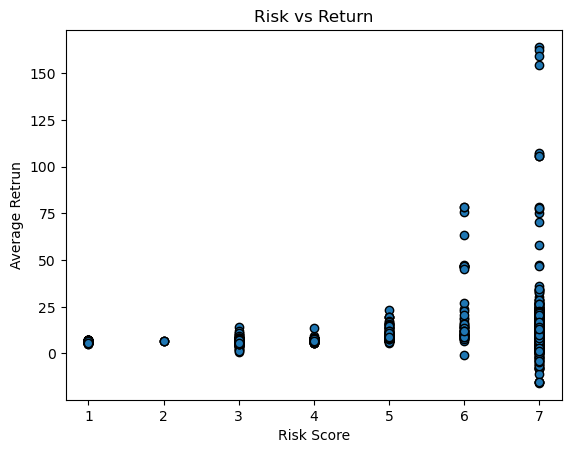

In [20]:
plt.scatter(df['risk_score'], df['avg_return'], edgecolors='black')
plt.xlabel('Risk Score')
plt.ylabel('Average Retrun')
plt.title('Risk vs Return')
plt.show()

### Key Observations
- Positive relationship: As risk scores increase, the potential average returns also increase.
- Low risk (scores 1–3): Returns are tightly clustered, generally modest, and rarely exceed moderate levels.
- Medium risk (scores 4–5): Returns start to spread out more, with some funds achieving strong gains but also showing wider variability.
- High risk (scores 6–7): Returns range from deep negatives (≈‑25) to extremely high (≈150+). This group shows the widest dispersion, reflecting both the potential for outsized gains and significant losses.

### Insights
- Risk–return trade‑off confirmed: The chart illustrates the classic investment principle — higher risk can lead to higher potential returns, but also greater downside.
- Volatility at the extremes: Funds with risk scores of 6–7 are highly unpredictable. They can deliver spectacular performance but also expose investors to steep losses.
- Balanced zone: Mid‑risk funds (scores 4–5) may represent a “sweet spot,” offering opportunities for strong returns without the extreme volatility of the highest risk group.

## What factors influence fund ranking?

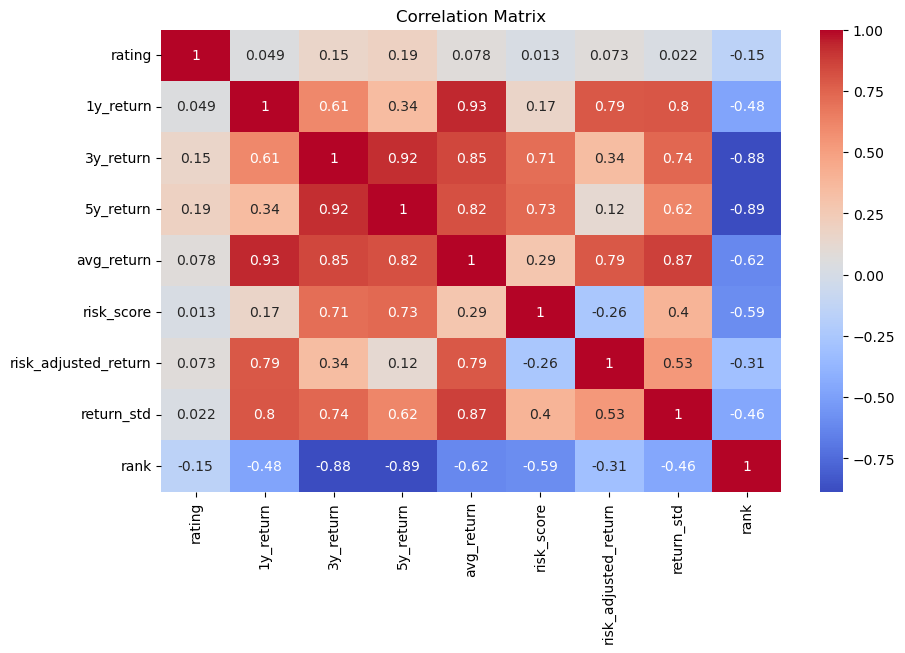

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(columns=['fund_age']).corr(numeric_only=True), annot=True, cmap='coolwarm' )
plt.title("Correlation Matrix")
plt.show()

### Key Observations
- Strong positive correlations among returns:
    - avg_return is highly correlated with 1y_return (0.93), 3y_return (0.85), and 5y_return (0.82).
    - This shows that the average return metric is largely driven by these individual horizon returns.


- Risk vs. return relationship:
    - risk_score has a moderate positive correlation with avg_return (≈0.45).
    - This supports the principle that higher risk tends to be associated with higher returns.


- Risk-adjusted return:
    - risk_adjusted_return correlates positively with avg_return (≈0.55), but less strongly with risk_score.
    - This indicates that funds delivering higher returns also tend to perform well on a risk-adjusted basis, though not perfectly.


- Volatility (return_std):
     - Strongly correlated with risk_score (≈0.78).
     - Confirms that higher risk scores are tied to higher return variability.


- Rank correlations:
    - rank has strong negative correlations with 3y_return (-0.88), 5y_return (-0.89), and avg_return (-0.62).
    - Lower ranks (better performance) are associated with higher returns, validating the ranking methodology.


### Insights
- Return consistency: The high correlations among 1Y, 3Y, and 5Y returns suggest that funds performing well in one horizon often perform well across others.
- Risk–reward trade-off: Higher risk scores align with both higher average returns and higher volatility, reinforcing the classic risk–return principle.
- Risk-adjusted efficiency: Some funds manage to deliver strong returns while maintaining favorable risk-adjusted scores, making them particularly attractive.
- Ranking validity: The strong negative correlation between rank and returns confirms that the ranking system effectively captures fund performance.

## Are highly rated funds really better performers?

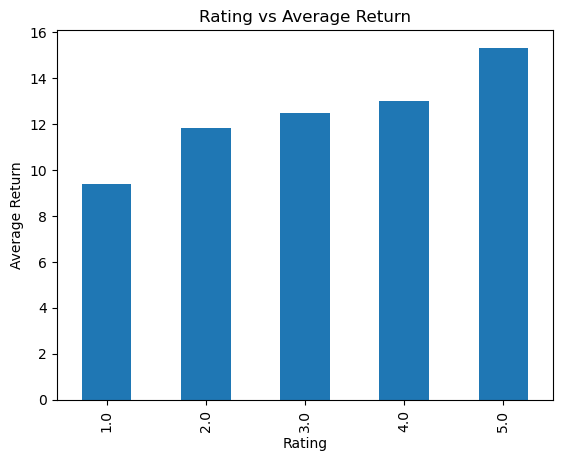

In [22]:
df.groupby('rating')['avg_return'].mean().plot(kind='bar')
plt.title('Rating vs Average Return')
plt.xlabel('Rating')
plt.ylabel('Average Return')
plt.show()

### Key Observations
- There is a clear upward trend: higher ratings correspond to higher average returns.
- Funds rated 1.0–2.0 deliver relatively low average returns.
- Ratings in the 3.0–4.0 range show noticeable improvement, with returns climbing steadily.
- The highest rating (5.0) is associated with the strongest average returns, peaking around 16.

### Insights
- Ratings are predictive of performance: The positive correlation suggests that the rating system is effective in distinguishing stronger funds from weaker ones.
- Investor confidence alignment: Higher ratings likely reflect better fundamentals, management, or historical performance, which translates into higher realized returns.
- Risk–reward validation: Lower‑rated funds may carry higher risks or weaker track records, explaining their lower average returns.

## Which mutual fund characteristics drive higher rank and better risk-adjusted performance?

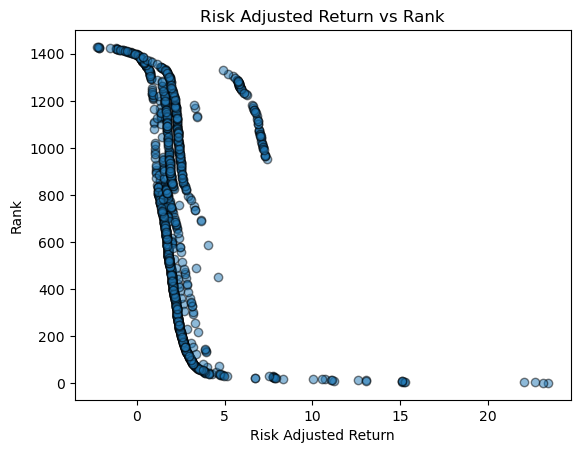

In [23]:
plt.scatter(df['risk_adjusted_return'],df['rank'], alpha=0.5, edgecolors='black')
plt.xlabel("Risk Adjusted Return")
plt.ylabel("Rank")
plt.title("Risk Adjusted Return vs Rank")
plt.show()

### Key Observations
- Dense cluster at low risk‑adjusted returns with high ranks:
    - Many funds sit in the lower risk‑adjusted return zone and correspondingly have weaker ranks.
    - This suggests that a large portion of funds are average or underperforming when risk is considered.

- Clear inverse relationship:
    - As risk‑adjusted return increases, rank decreases (improves).
    - This validates the ranking system as being aligned with efficiency in balancing risk and reward.

### Insights
- Ranking credibility: The strong inverse relationship shows that the ranking methodology is consistent — better risk‑adjusted performers are rewarded with superior ranks.
- Market skew: The dense clustering at low returns highlights that most funds fail to deliver strong risk‑adjusted performance, making top performers relatively rare.

In [24]:
# top 10 fund by Risk Adjusted Return
df.sort_values(by='risk_adjusted_return', ascending=False).head(10)

,fund_name,risk,category,rating,1y_return,3y_return,5y_return,1y_return_band,3y_return_band,5y_return_band,avg_return,risk_score,risk_adjusted_return,return_std,fund_age,rank,fund_age_group
16,SBI Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,164.16,NaN,NaN,High,No Data,No Data,164.160,7,23.451429,NaN,1,1.0,New (≤1Y history)
219,Kotak Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,162.27,NaN,NaN,High,No Data,No Data,162.270,7,23.181429,NaN,1,2.0,New (≤1Y history)
285,UTI Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,159.07,NaN,NaN,High,No Data,No Data,159.070,7,22.724286,NaN,1,3.0,New (≤1Y history)
21,Tata Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,154.48,NaN,NaN,High,No Data,No Data,154.480,7,22.068571,NaN,1,4.0,New (≤1Y history)
29,Axis Silver FoF Direct Growth,Very High Risk,Commodities,3.0,160.72,53.63,NaN,High,High,No Data,107.175,7,15.310714,75.724065,2,5.0,Mid-age (≤3Y history)
0,HDFC Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,159.93,53.58,NaN,High,High,No Data,106.755,7,15.250714,75.200806,2,6.0,Mid-age (≤3Y history)
5,Nippon India Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,158.60,53.12,NaN,High,High,No Data,105.860,7,15.122857,74.585623,2,7.0,Mid-age (≤3Y history)
59,ICICI Prudential Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,158.52,53.08,NaN,High,High,No Data,105.800,7,15.114286,74.557339,2,8.0,Mid-age (≤3Y history)
10,Aditya Birla Sun Life Silver ETF FoF Direct Gr...,Very High Risk,Commodities,3.0,158.57,52.99,NaN,High,High,No Data,105.780,7,15.111429,74.656334,2,9.0,Mid-age (≤3Y history)
441,DSP Gold ETF FoF Direct Growth,High Risk,Commodities,2.0,78.40,NaN,NaN,High,No Data,No Data,78.400,6,13.066667,NaN,1,11.0,New (≤1Y history)


### Key Observations
- Silver FoF funds dominate the top ranks:
    - SBI, Kotak, UTI, Tata, Axis, HDFC, Nippon, ICICI, and Aditya Birla Silver FoFs all appear in the top 10 ranks.
    - Their 1Y returns are exceptionally high (≈154–164%), reflecting the strong rally in silver prices.

- Risk profile:
    - All Silver FoFs are classified as “Very High Risk” with a risk score of 7, the maximum.
    - Their risk‑adjusted returns (≈15–23) are strong, but volatility (return_std) is very high (≈75), confirming extreme price swings.

- Fund age:
    - Most Silver FoFs are very new (1–2 years old), meaning they lack long‑term performance history (3Y and 5Y data often missing).
    - This limits confidence in their sustainability despite stellar short‑term returns.

- Gold FoF comparison:
    - DSP Gold ETF FoF (rank 11) shows much lower 1Y return (≈78%) compared to Silver FoFs.
    - Risk score is slightly lower (6 vs 7), and risk‑adjusted return is ≈13, still respectable but far below Silver.
    - Gold funds are more established and less volatile, but currently underperform relative to silver.

### Insights
- Silver surge: The extraordinary 1Y returns of Silver FoFs highlight a commodity‑driven boom. However, their extreme risk scores and volatility suggest these gains are not guaranteed to persist.
- Short track record risk: Most Silver FoFs are very young, so investors lack visibility into how they perform across market cycles. This makes them speculative despite high rankings.
- Gold as a stabilizer: Gold FoFs deliver lower returns but with relatively lower risk. They remain a safer commodity play compared to silver.

In [25]:
# Top 10 funds by ranking

df.sort_values(by='rank', ascending=True).head(10)

,fund_name,risk,category,rating,1y_return,3y_return,5y_return,1y_return_band,3y_return_band,5y_return_band,avg_return,risk_score,risk_adjusted_return,return_std,fund_age,rank,fund_age_group
16,SBI Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,164.16,NaN,NaN,High,No Data,No Data,164.160,7,23.451429,NaN,1,1.0,New (≤1Y history)
219,Kotak Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,162.27,NaN,NaN,High,No Data,No Data,162.270,7,23.181429,NaN,1,2.0,New (≤1Y history)
285,UTI Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,159.07,NaN,NaN,High,No Data,No Data,159.070,7,22.724286,NaN,1,3.0,New (≤1Y history)
21,Tata Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,154.48,NaN,NaN,High,No Data,No Data,154.480,7,22.068571,NaN,1,4.0,New (≤1Y history)
29,Axis Silver FoF Direct Growth,Very High Risk,Commodities,3.0,160.72,53.63,NaN,High,High,No Data,107.175,7,15.310714,75.724065,2,5.0,Mid-age (≤3Y history)
0,HDFC Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,159.93,53.58,NaN,High,High,No Data,106.755,7,15.250714,75.200806,2,6.0,Mid-age (≤3Y history)
5,Nippon India Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,158.60,53.12,NaN,High,High,No Data,105.860,7,15.122857,74.585623,2,7.0,Mid-age (≤3Y history)
59,ICICI Prudential Silver ETF FoF Direct Growth,Very High Risk,Commodities,3.0,158.52,53.08,NaN,High,High,No Data,105.800,7,15.114286,74.557339,2,8.0,Mid-age (≤3Y history)
10,Aditya Birla Sun Life Silver ETF FoF Direct Gr...,Very High Risk,Commodities,3.0,158.57,52.99,NaN,High,High,No Data,105.780,7,15.111429,74.656334,2,9.0,Mid-age (≤3Y history)
17,Edelweiss Gold and Silver ETF FoF Direct Growth,Very High Risk,Commodities,5.0,112.93,44.16,NaN,High,High,No Data,78.545,7,11.220714,48.627733,2,10.0,Mid-age (≤3Y history)


### Key Observations
- Silver FoFs dominate the top ranks (1–9):
    - SBI, Kotak, UTI, Tata, Axis, HDFC, Nippon, ICICI, and Aditya Birla Silver FoFs all rank within the top 10.
    - Their 1Y returns are exceptionally high (≈154–164%), reflecting the strong rally in silver prices.
    - Risk scores are uniformly 7 (Very High Risk), the maximum.

- Fund age:
    - Most Silver FoFs are very new (1–2 years old), with limited long‑term performance history.
    - 3Y and 5Y returns are missing for many, highlighting the lack of track record.

- Risk‑adjusted returns:
    - Top Silver FoFs show strong risk‑adjusted returns (≈15–23), but volatility (return_std) is extremely high (≈75).
    - This confirms that while returns are spectacular, they come with significant swings.

- Edelweiss Gold & Silver FoF (rank 10):
    - More balanced profile: 1Y return ≈113%, 3Y return ≈44%.
    - Risk‑adjusted return is lower (≈11), with volatility ≈49 — less extreme than pure Silver FoFs.
    - Rating is higher (5.0 vs 3.0 for others), suggesting stronger perceived quality.

### Insights
- Silver surge: Silver FoFs are delivering explosive short‑term gains, but their extreme risk scores and volatility make them speculative bets.
- Track record gap: Most Silver FoFs are too young to prove sustainability. Their rankings are driven by recent silver price spikes rather than long‑term consistency.
- Gold & Silver blend: Edelweiss Gold & Silver FoF offers a more balanced profile — lower returns than pure silver, but also lower volatility and a higher rating. This makes it a more stable commodity play.

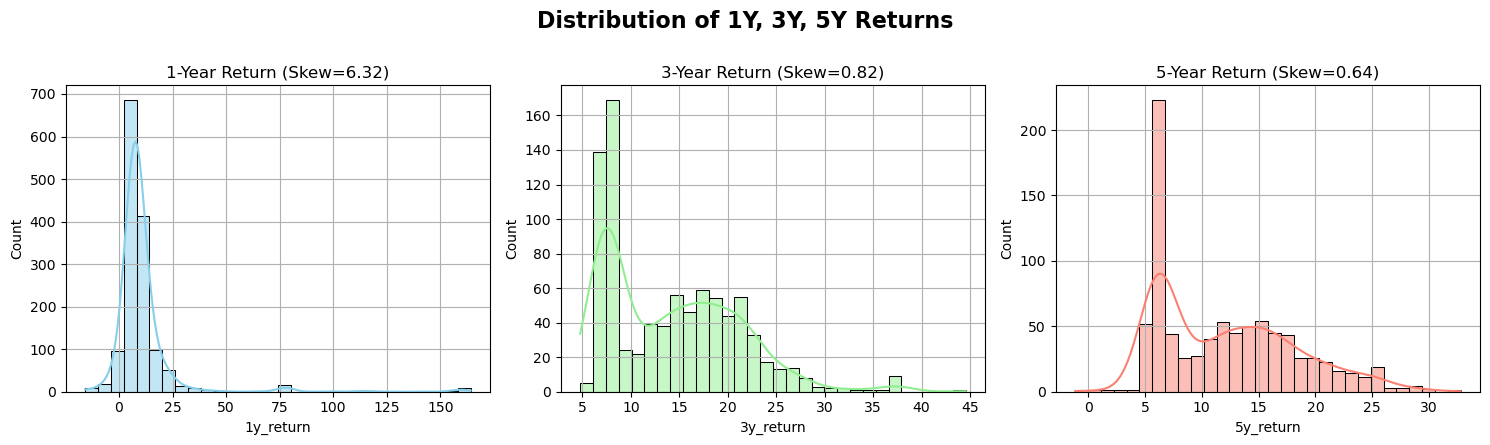

In [26]:
# Distribution of 1Y, 3Y, 5Y Returns

fig, axs = plt.subplots(1,3, figsize=(15,4))

sns.histplot(df['1y_return'], bins=30, kde=True, color='skyblue', ax=axs[0])
axs[0].set_title(f"1-Year Return (Skew={skew(df['1y_return']):.2f})")
axs[0].grid(True)

sns.histplot(df_eda['3y_return'], bins=30, kde=True, color='lightgreen', ax=axs[1])
axs[1].set_title(f"3-Year Return (Skew={skew(df_eda['3y_return']):.2f})")
axs[1].grid(True)

sns.histplot(df_eda['5y_return'], bins=30, kde=True, color='salmon', ax=axs[2])
axs[2].set_title(f"5-Year Return (Skew={skew(df_eda['5y_return']):.2f})")
axs[2].grid(True)

plt.tight_layout()
plt.suptitle('Distribution of 1Y, 3Y, 5Y Returns', fontweight='bold', fontsize=16, y=1.1)
plt.show()

### Key Observations
- 1-Year Return (Skew = 6.32)
    - Extremely positively skewed.
    - Most funds cluster around modest returns (~10), but a few outliers deliver very high returns (>150).
    - This indicates short‑term performance is highly volatile, with rare but extreme winners.

- 3-Year Return (Skew = 0.82)
    - Moderately skewed to the right.
    - Distribution is more balanced, with a peak around ~10 and fewer extreme outliers.
    - Suggests medium‑term returns smooth out volatility compared to 1Y.

- 5-Year Return (Skew = 0.64)
    - Slightly skewed to the right.
    - Peak shifts lower (~7), with a more even spread across funds.
    - Long‑term returns are more stable, with fewer extreme highs and a tighter distribution.

### Insights
- Volatility dampens over time: The skewness decreases from 6.32 (1Y) → 0.82 (3Y) → 0.64 (5Y). This shows that extreme short‑term gains/losses tend to normalize over longer horizons.
- Outliers dominate short‑term: A handful of funds drive the extreme 1Y skew, but their influence diminishes in 3Y and 5Y views.
- Consistency improves with maturity: By 5Y, most funds deliver moderate, predictable returns, reinforcing the value of long‑term investing.

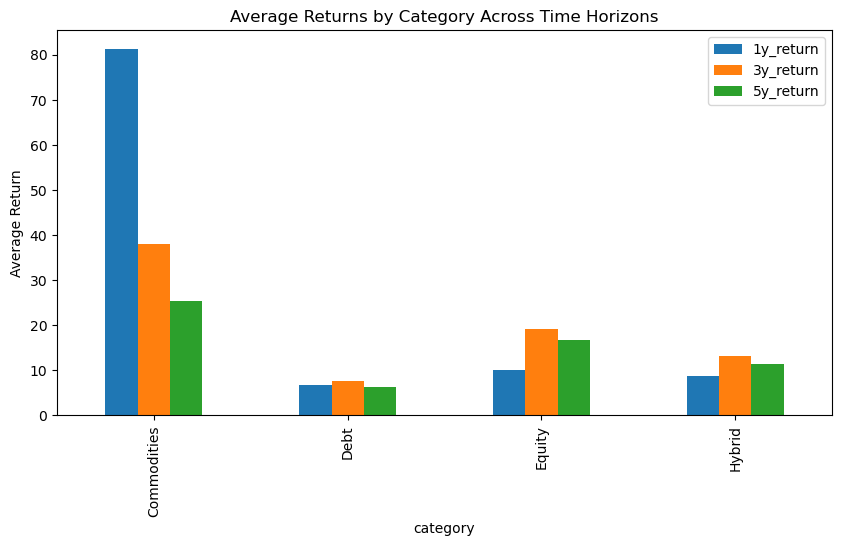

In [27]:
df_eda.groupby('category')[['1y_return','3y_return','5y_return']].mean().plot(kind='bar', figsize=(10,5))
plt.title("Average Returns by Category Across Time Horizons")
plt.ylabel("Average Return")
plt.show()

### Key Observations
- Commodities
    - Deliver the highest average returns in the 1‑year horizon, far ahead of other categories.
    - Returns taper off in longer horizons, showing strong short‑term spikes but less consistency.

- Equity
    - Moderate in the 1‑year horizon, but strongest in the 3‑year horizon.
    - This suggests equities compound well over medium‑term periods.

- Hybrid
    - Returns are steady but lower than equities, reflecting their balanced exposure to equity and debt.
    - They provide stability but sacrifice some upside.

- Debt
    - Consistently the lowest average returns across all horizons.
    - Reflects their role as safer, income‑oriented investments rather than growth drivers.

### Insights
- Short‑term vs long‑term dynamics: Commodities shine in the short term but lack sustained performance, while equities build strength over 3‑year horizons.
- Risk–return trade‑off: Debt funds are safest but least rewarding, hybrids sit in the middle, and equities/commodities offer higher growth with more volatility.

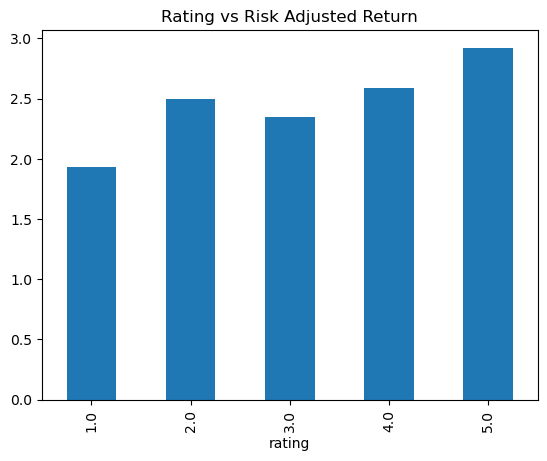

In [28]:
df.groupby('rating')['risk_adjusted_return'].mean().plot(kind='bar')
plt.title("Rating vs Risk Adjusted Return")
plt.show()

### Key Observations
- Positive relationship overall: Higher ratings generally correspond to higher risk‑adjusted returns.
    - Rating 1.0 -> 2.0 risk‑adjusted return (lowest).
    - Rating 2.0 -> 2.5, showing improvement.
    - Rating 3.0 -> 2.3, a slight dip compared to 2.0.
    - Rating 4.0 -> 2.6, back on the upward trend.
    - Rating 5.0 -> 2.9, the highest risk‑adjusted return.

### Insights
- Ratings are meaningful predictors: The upward slope suggests that higher‑rated funds tend to deliver better efficiency when balancing risk and return.
- Non‑linear pattern: The dip at rating 3.0 shows that not all mid‑rated funds are equally efficient — some may carry risk without proportionate reward.
- Top‑rated funds stand out: Rating 5.0 funds achieve the strongest risk‑adjusted returns, reinforcing the value of focusing on the best‑rated options.

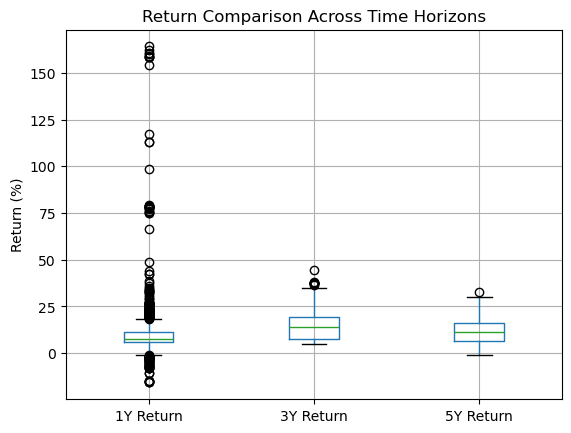

In [29]:
# 1Y, 3Y, 5Y Returns comparison (boxplot)

df_compare = pd.DataFrame({
    '1Y Return': df['1y_return'],
    '3Y Return': df_eda['3y_return'],
    '5Y Return': df['5y_return']
})

df_compare.boxplot()
plt.title("Return Comparison Across Time Horizons")
plt.ylabel("Return (%)")
plt.show()

### Key Observations
- 1‑Year Returns
    - Very wide spread with many outliers.
    - Median is higher than longer horizons, but variability is extreme.
    - Indicates short‑term investing is highly volatile, with both spectacular gains and steep losses.

- 3‑Year Returns
    - Distribution is more compact.
    - Fewer outliers compared to 1Y, showing reduced volatility.
    - Median return is moderate, suggesting more predictable performance.

- 5‑Year Returns
    - Tightest distribution among the three horizons.
    - Very few outliers, reflecting stability.
    - Median return is slightly lower than 3Y, but consistency is much stronger.

### Insights
- Volatility decreases with time: The box plots clearly show that short‑term returns are erratic, while medium‑ and long‑term horizons smooth out extremes.
- Risk–reward trade‑off: 1Y investing offers the chance of outsized gains but carries high risk. Longer horizons reduce risk but also temper the possibility of extreme upside.
- Consistency improves with maturity: By 5Y, returns cluster tightly around the median, making long‑term investing more reliable.

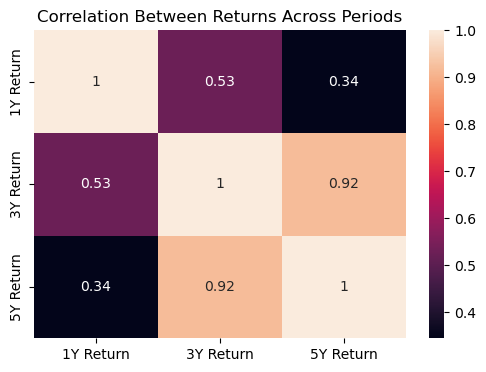

In [30]:
# Correlation of Returns

plt.figure(figsize=(6,4))
sns.heatmap(df_compare[['1Y Return','3Y Return','5Y Return']].corr(), annot=True)
plt.title("Correlation Between Returns Across Periods")
plt.show()

### Key Observations
- 1Y vs 3Y correlation = 0.53
    - Moderate relationship. Short‑term returns only partially explain medium‑term performance.
    - Indicates that 1‑year winners don’t always sustain into 3 years.

- 1Y vs 5Y correlation = 0.34
    - Weak relationship. Short‑term results are poor predictors of long‑term outcomes.
    - Reinforces that chasing 1‑year highs is risky.

- 3Y vs 5Y correlation = 0.92
    - Very strong relationship. Medium‑term performance aligns closely with long‑term outcomes.
    - Funds that perform well over 3 years are highly likely to continue delivering over 5 years.

### Insights
- Short‑term volatility: 1‑year returns are noisy and heavily influenced by market cycles, making them unreliable for long‑term fund selection.
- Medium‑term as a predictor: 3‑year returns are a strong leading indicator of 5‑year performance, offering a reliable horizon for evaluating consistency.

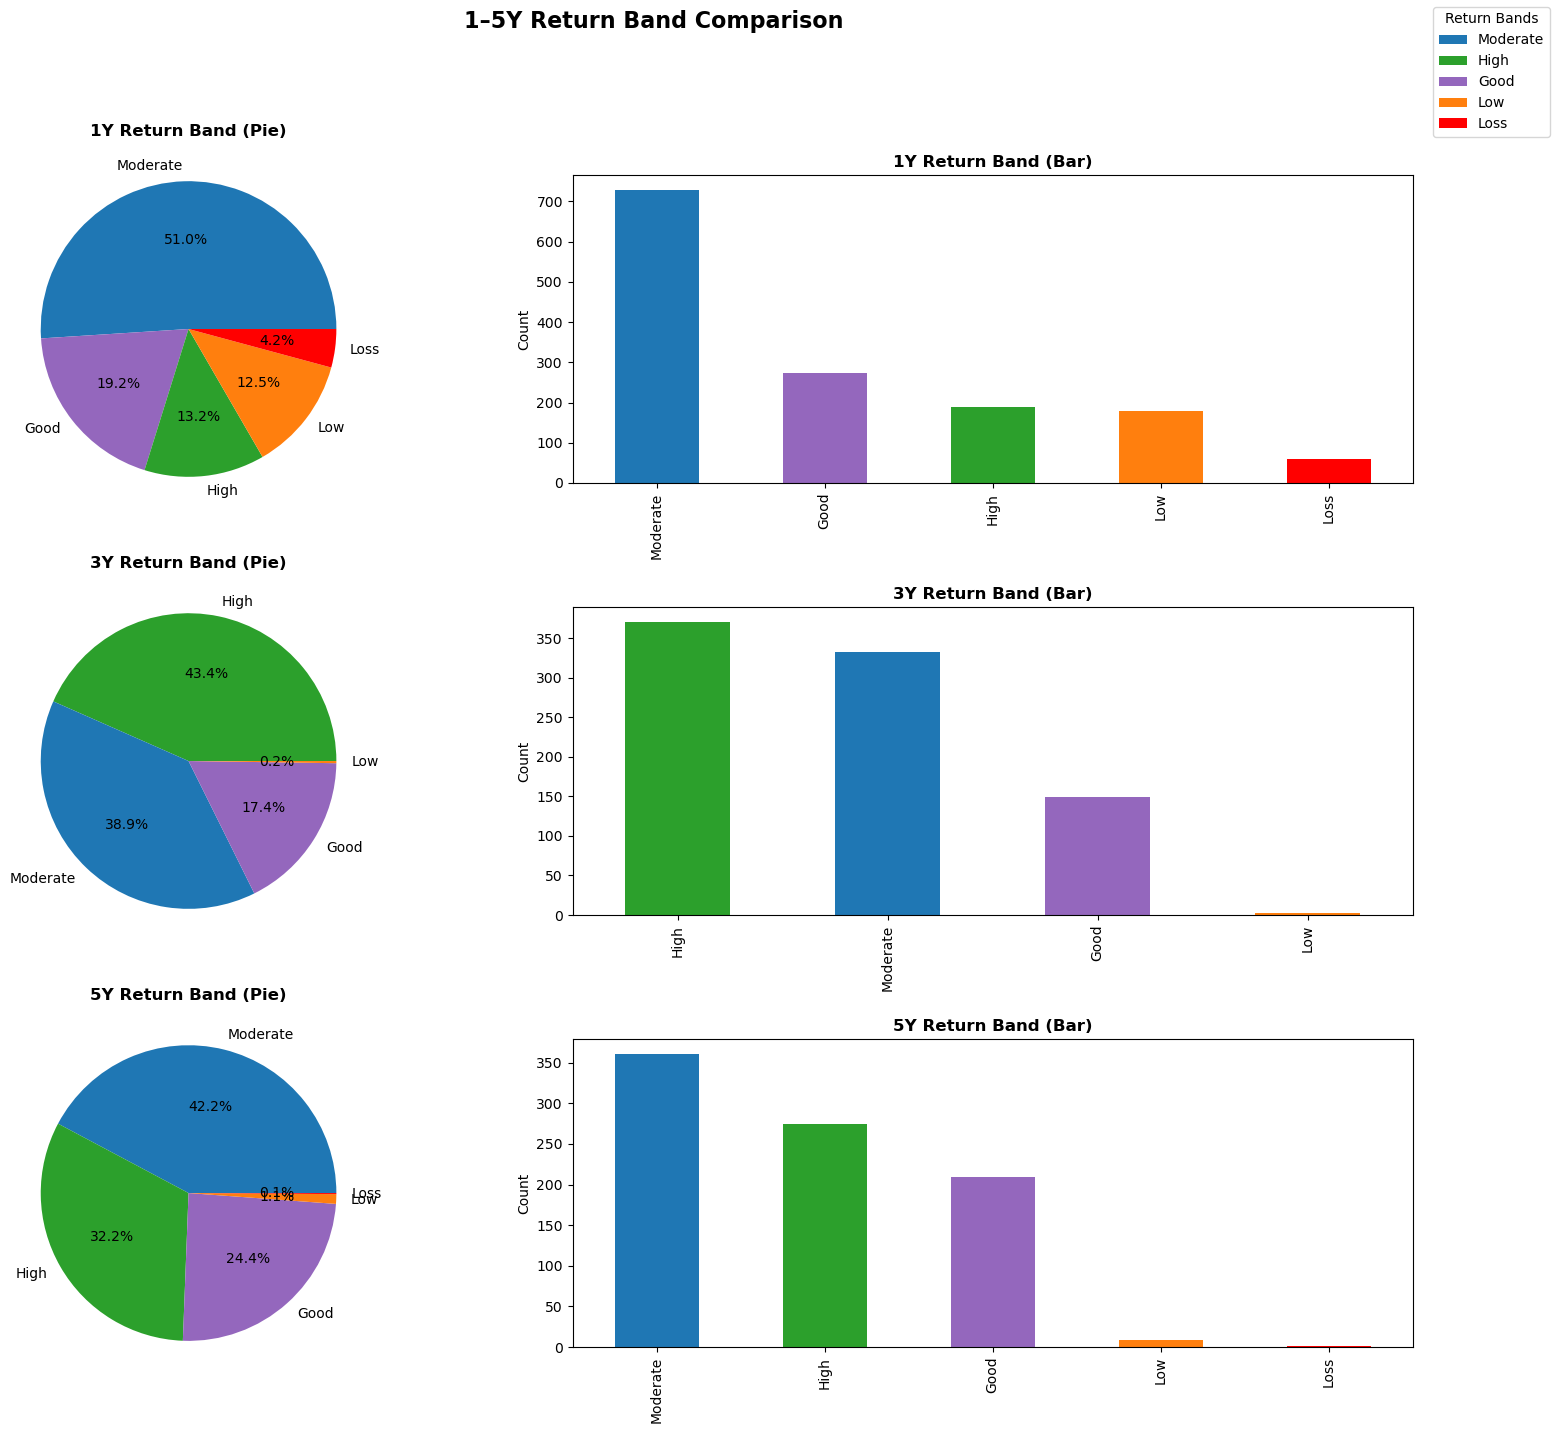

In [31]:
# Define a consistent color mapping
band_colors = { 'Loss': 'red', 
               'Low': '#ff7f0e',
               'Moderate': '#1f77b4',
               'Good': '#9467bd',
               'High': '#2ca02c' }

fig, axes = plt.subplots(3, 2, figsize=(18,14))

# --- 1Y Return Band ---
df['1y_return_band'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=axes[0,0], radius=1.2,
    colors=[band_colors[x] for x in df['1y_return_band'].value_counts().index],
    legend=False
)
axes[0,0].set_title('1Y Return Band (Pie)', fontweight='bold', y=1.10)
axes[0,0].set_ylabel('')

df['1y_return_band'].value_counts().plot(
    kind='bar', ax=axes[0,1], 
    color=[band_colors[x] for x in df['1y_return_band'].value_counts().index]
)
axes[0,1].set_title('1Y Return Band (Bar)', fontweight='bold')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xlabel('')

# --- 3Y Return Band ---
df_eda['3y_return_band'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=axes[1,0], radius=1.2,
    colors=[band_colors[x] for x in df_eda['3y_return_band'].value_counts().index],
    legend=False
)
axes[1,0].set_title('3Y Return Band (Pie)', fontweight='bold' ,y=1.10)
axes[1,0].set_ylabel('')

df_eda['3y_return_band'].value_counts().plot(
    kind='bar', ax=axes[1,1], 
    color=[band_colors[x] for x in df_eda['3y_return_band'].value_counts().index]
)
axes[1,1].set_title('3Y Return Band (Bar)', fontweight='bold')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xlabel('')

# --- 5Y Return Band ---
df_eda['5y_return_band'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=axes[2,0], radius=1.2,
    colors=[band_colors[x] for x in df_eda['5y_return_band'].value_counts().index],

)
axes[2,0].set_title('5Y Return Band (Pie)', fontweight='bold', y=1.10)
axes[2,0].set_ylabel('')

df_eda['5y_return_band'].value_counts().plot(kind='bar', ax=axes[2,1], 
    color=[band_colors[x] for x in df_eda['5y_return_band'].value_counts().index]
)
axes[2,1].set_title('5Y Return Band (Bar)', fontweight='bold')
axes[2,1].set_ylabel('Count')
axes[2,1].set_xlabel('')

# --- Common Legend for Pie Charts ---
handles, labels = axes[2,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Return Bands')

plt.tight_layout(rect=[0,0,0.93,0.95], w_pad=2, h_pad=2)
plt.suptitle('1–5Y Return Band Comparison', fontweight='bold', fontsize=16, y=1.02)
plt.show()

### Key Observations
- 1‑Year Returns
    - Majority of funds fall into the Moderate band (51%).
    - Smaller but notable shares in Good (19%) and High (13%) bands.
    - Losses are present (≈4%), showing short‑term volatility.

- 3‑Year Returns
    - Strong shift toward High band (43%), with Moderate (39%) close behind.
    - Good band (17%) remains meaningful.
    - Losses almost disappear, showing improved stability over time.

- 5‑Year Returns
    - Distribution balances out: Moderate (42%), High (32%), and Good (24%).
    - Losses are negligible (≈0.1%), confirming long‑term resilience.
    - Very few funds in the Low band, indicating most achieve at least moderate returns.

### Insights
- Short‑term volatility: The 1Y horizon shows the widest spread, with meaningful losses and extreme highs. Investors face higher uncertainty in the short run.
- Medium‑term strength: At 3Y, the High band dominates, suggesting many funds peak in performance during this horizon. Losses nearly vanish, making 3Y a strong predictor of sustainability.
- Long‑term consistency: By 5Y, returns stabilize across Moderate, High, and Good bands. Losses are almost eliminated, reinforcing the value of long‑term holding.

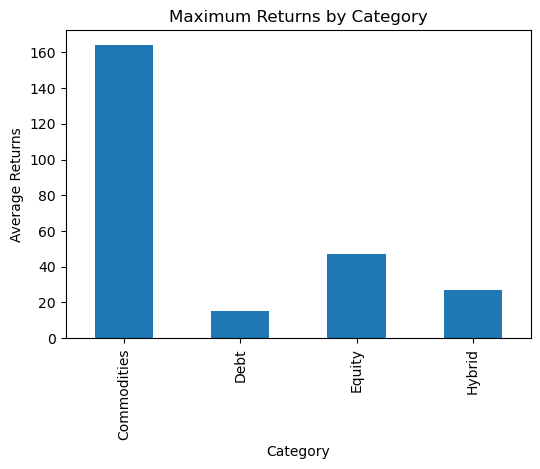

In [45]:
df.groupby('category')['avg_return'].max().plot(kind='bar', figsize=(6,4))
plt.title('Maximum Returns by Category')
plt.xlabel('Category')
plt.ylabel('Maximum Returns')
plt.show()

### Key Observations
- Commodities dominate: With average returns around 165, commodities far outperform all other categories. This suggests high potential gains but likely comes with higher volatility and risk.
- Equity is the next best: At ~47, equities provide solid returns, though far below commodities. This aligns with the general expectation that equities outperform debt and hybrid instruments over time.
- Hybrid offers moderate returns: Averaging ~28, hybrids balance risk and reward, making them suitable for investors seeking stability with some growth.
- Debt is the lowest: At ~17, debt instruments provide the most stable but least lucrative returns, consistent with their role as safe, low-risk investments.

### Insights
- Risk vs. Reward: Commodities may look attractive, but their extreme outperformance often comes with significant risk. Equities and hybrids provide more balanced options.
- Portfolio Diversification: A mix of equity and hybrid could offer a safer growth path, while commodities can be used selectively for aggressive growth.
- Investor Profile Fit:
    - Conservative → Debt/Hybrid
    - Moderate → Equity/Hybrid